# Exploring and Analysing 2016 US Bike Share Data

## Table of Contents
- [Introduction](#intro)
- [Posing Questions](#pose_questions)
- [Data Collection and Wrangling](#wrangling)
  - [Condensing the Trip Data](#condensing)
- [Exploratory Data Analysis](#eda)
  - [Statistics](#statistics)
  - [Visualizations](#visualizations)
- [Performing One Last Analysis](#eda_continued)
- [Conclusions](#conclusions)

<a id='intro'></a>
## Introduction


Over the past decade, bicycle-sharing systems have been growing in number and popularity in cities across the world. Bicycle-sharing systems allow users to rent bicycles for short trips, typically 30 minutes or less. Thanks to the rise in information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.

In this project, I will perform an exploratory analysis on data provided by [Motivate](https://www.motivateco.com/), a bike-share system provider for many major cities in the United States. I will compare the system usage between three large cities: New York City, Chicago, and Washington, DC. I will also see if there are any differences within each system for those users that are registered, regular users and those users that are short-term, casual users.

<a id='pose_questions'></a>
## Posing Questions (Examples)

**Question 1**: How often do people share bikes for travelling?

**Question 2**: What is the average ride time for which people share bikes?

<a id='wrangling'></a>
## Data Collection and Wrangling

Now it's time to collect and explore our data. In this project, I will focus on the record of individual trips taken in 2016 from our selected cities: New York City, Chicago, and Washington, DC. Each of these cities has a page where we can freely download the trip data.:

- New York City (Citi Bike): [Link](https://www.citibikenyc.com/system-data)
- Chicago (Divvy): [Link](https://www.divvybikes.com/system-data)
- Washington, DC (Capital Bikeshare): [Link](https://www.capitalbikeshare.com/system-data)

In these pages, I noticed that each city has a different way of delivering its data. Chicago updates with new data twice a year, Washington DC is quarterly, and New York City is monthly. The data has already been collected in the `/data/` folder of the project files. While the original data for 2016 is spread among multiple files for each city, the files in the `/data/` folder collect all of the trip data for the year into one file per city. Some data wrangling of inconsistencies in timestamp format within each city has already been performed. In addition, a random 2% sample of the original data is taken to make the exploration more manageable. 

There is still a lot of data for us to investigate, so it's a good idea to start off by looking at one entry from each of the cities we're going to analyze. 

Loading some packages and functions that I'll be using in my analysis. 

In [1]:
## Importing all necessary packages and functions.
import csv                       ## Read and write csv files
from datetime import datetime    ## Operations to parse dates
from pprint import pprint        ## Used to print data structures like dictionaries in
                                 ## a nicer way than the base print function.

Printing out the first trip recorded from each of the cities (the second line of each data file).

In [2]:
def print_first_point(filename):
    """
    This function prints and returns the first data point (second row) from
    a csv file that includes a header row.
    """
    
    ## Printing city name for reference.
    city = filename.split('-')[0].split('/')[-1]
    print('\nCity: {}'.format(city))
    
    with open(filename, 'r') as f_in:
        ## Using the csv library to set up a DictReader object. 
        trip_reader = csv.DictReader(f_in)
        
        ## Using a function on the DictReader object to read the 
        ## first trip from the data file and storing it in a variable.
        first_trip = trip_reader.__next__()
        
        ## Using the pprint library to print the first trip.
        pprint(first_trip)
        
    ## Output city name and first trip for later testing
    return (city, first_trip)

## List of files for each city
data_files = ['./data/NYC-CitiBike-2016.csv',
              './data/Chicago-Divvy-2016.csv',
              './data/Washington-CapitalBikeshare-2016.csv']

## Print the first trip from each file, storing in dictionary.
example_trips = {}
for data_file in data_files:
    city, first_trip = print_first_point(data_file)
    example_trips[city] = first_trip


City: NYC
OrderedDict([('tripduration', '839'),
             ('starttime', '1/1/2016 00:09:55'),
             ('stoptime', '1/1/2016 00:23:54'),
             ('start station id', '532'),
             ('start station name', 'S 5 Pl & S 4 St'),
             ('start station latitude', '40.710451'),
             ('start station longitude', '-73.960876'),
             ('end station id', '401'),
             ('end station name', 'Allen St & Rivington St'),
             ('end station latitude', '40.72019576'),
             ('end station longitude', '-73.98997825'),
             ('bikeid', '17109'),
             ('usertype', 'Customer'),
             ('birth year', ''),
             ('gender', '0')])

City: Chicago
OrderedDict([('trip_id', '9080545'),
             ('starttime', '3/31/2016 23:30'),
             ('stoptime', '3/31/2016 23:46'),
             ('bikeid', '2295'),
             ('tripduration', '926'),
             ('from_station_id', '156'),
             ('from_station_name', 'Clar

We can see above from the printout of each city name (which has been parsed from the data file name), the first trip has been parsed in the form of a dictionary.


<a id='condensing'></a>
### Condensing the Trip Data

It should also be observable from the above printout that each city provides different information. Even where the information is the same, the column names and formats are sometimes different. To make things as simple as possible when we get to the actual exploration, we should trim and clean the data. Cleaning the data makes sure that the data formats across the cities are consistent, while trimming focuses only on the parts of the data we are most interested in to make the exploration easier to work with.

I will generate new data files with five values of interest for each trip: trip duration, starting month, starting hour, day of the week, and user type. Each of these may require additional wrangling depending on the city:

- **Duration**: This has been given to us in seconds (New York, Chicago) or milliseconds (Washington). A more natural unit of analysis will be if all the trip durations are given in terms of minutes.
- **Month**, **Hour**, **Day of Week**: Ridership volume is likely to change based on the season, time of day, and whether it is a weekday or weekend. The New York City data includes the seconds in their timestamps, while Washington and Chicago do not.
- **User Type**: It is possible that users who are subscribed to a bike-share system will have different patterns of use compared to users who only have temporary passes. Washington divides its users into two types: 'Registered' for users with annual, monthly, and other longer-term subscriptions, and 'Casual', for users with 24-hour, 3-day, and other short-term passes. The New York and Chicago data uses 'Subscriber' and 'Customer' for these groups, respectively. For consistency, I will convert the Washington labels to match the other two.


Making the functions in the code cells below to address each of the cleaning tasks described above.

In [3]:
def duration_in_mins(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the trip duration in units of minutes. 
    """
    
    ## Converting the duration time in float for all the 3 cities from string.
    
    ## Converting duration time in minutes from 'milliseconds' for Washington.
    if city=='Washington':
        duration = (float((datum.get('Duration (ms)'))))/60000
    
    ## Converting duration time in minutes from 'seconds' for Chicago and NYC.
    if city=='Chicago':
        duration = (float(datum.get('tripduration')))/60
    if city=='NYC':
        duration = (float(datum.get('tripduration')))/60
        
    ## Returning the duration time(in minutes) for the respective city.
    return duration

In [4]:
def time_of_trip(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the month, hour, and day of the week in
    which the trip was made.
    """
    
    ## Getting a datetime object for the respective city and extracting month, hour and day_of_week from it. 
    ## NYC includes seconds, while Washington and Chicago do not.
    if city=='NYC':
        d=datetime.strptime(datum.get('starttime'),'%m/%d/%Y %H:%M:%S')
        month=d.month
        hour=d.hour
        day_of_week=d.strftime('%A')
    elif city=='Washington':
        d=datetime.strptime(datum.get('Start date'),'%m/%d/%Y %H:%M')
        month=d.month
        hour=d.hour
        day_of_week=d.strftime('%A')
    else:
        d=datetime.strptime(datum.get('starttime'),'%m/%d/%Y %H:%M')
        month=d.month
        hour=d.hour
        day_of_week=d.strftime('%A')
        
    ## Returning month,hour and day_of_week as a tuple for the respective city.    
    return (month, hour, day_of_week)

In [5]:
def type_of_user(datum, city):
    """
    Takes as input a dictionary containing info about a single trip (datum) and
    its origin city (city) and returns the type of system user that made the
    trip.
    """
    
    ## Washington has different category names compared to Chicago and NYC. 
    
    ## For washington, if Member Type is Casual, I will assign the user_type to be Customer 
    ## and if Member Type is Registered, I will assign the user_type to be Subscriber.
    if city=='Washington':
        if datum.get('Member Type')=='Casual':
            user_type="Customer"
        else:
            user_type="Subscriber"
    ## For NYC and Chicago, I will simply return the usertype of the user, whichever is already mentioned in the data.
    else:
        user_type=datum.get('usertype')
        
    ## Returning the type of user for the respective city.    
    return user_type

Now, Using the helper functions I wrote above to create a condensed data file for each city consisting only of the data fields indicated above.

In [6]:
def condense_data(in_file, out_file, city):
    """
    This function takes full data from the specified input file
    and writes the condensed data to a specified output file. The city
    argument determines how the input file will be parsed.
    """
    
    with open(out_file, 'w') as f_out, open(in_file, 'r') as f_in:
        ## Setting up csv DictWriter object.
        out_colnames = ['duration', 'month', 'hour', 'day_of_week', 'user_type']        
        trip_writer = csv.DictWriter(f_out, fieldnames = out_colnames)
        trip_writer.writeheader()
        
        ## Setting up csv DictReader object
        trip_reader = csv.DictReader(f_in)

        
        ## Creating an empty list to append all the individual rows in this list and wite the complete list to the output file.
        list_of_rows=[]
        
        ## Collecting data from and process each row
        for row in trip_reader:
            ## Recieving the tuple(returned from the time_of_trip function) in a variable for ease of access using indices.
            time_of_trip_tuple=time_of_trip(row,city)
            
            ## Setting up a dictionary to hold the values for the cleaned and trimmed data point
            new_point = {'duration':duration_in_mins(row,city),
                            'month':time_of_trip_tuple[0],
                            'hour':time_of_trip_tuple[1],
                            'day_of_week':time_of_trip_tuple[2],
                            'user_type':type_of_user(row,city)}

            ## Using the helper functions to get the cleaned data from
            ## the original data dictionaries. Writing the processed information to the output file.
            
            ## Appending each row to the newly created list.
            list_of_rows.append(new_point)
        
        ## Writing the list to the Dictwriter object.
        trip_writer.writerows(list_of_rows)   

In [7]:
## Cell to check my work.
city_info = {'Washington': {'in_file': './data/Washington-CapitalBikeshare-2016.csv',
                            'out_file': './data/Washington-2016-Summary.csv'},
             'Chicago': {'in_file': './data/Chicago-Divvy-2016.csv',
                         'out_file': './data/Chicago-2016-Summary.csv'},
             'NYC': {'in_file': './data/NYC-CitiBike-2016.csv',
                     'out_file': './data/NYC-2016-Summary.csv'}}

for city, filenames in city_info.items():
    condense_data(filenames['in_file'], filenames['out_file'], city)
    print_first_point(filenames['out_file'])


City: Washington
OrderedDict([('duration', '7.123116666666666'),
             ('month', '3'),
             ('hour', '22'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: Chicago
OrderedDict([('duration', '15.433333333333334'),
             ('month', '3'),
             ('hour', '23'),
             ('day_of_week', 'Thursday'),
             ('user_type', 'Subscriber')])

City: NYC
OrderedDict([('duration', '13.983333333333333'),
             ('month', '1'),
             ('hour', '0'),
             ('day_of_week', 'Friday'),
             ('user_type', 'Customer')])


<a id='eda'></a>
## Exploratory Data Analysis

Now that I have the data collected and wrangled, I'm ready to start exploring the data. In this section I will write some code to compute descriptive statistics from the data. I will also use the `matplotlib` library to create some basic histograms of the data.

<a id='statistics'></a>
### Statistics

First, let's compute some basic counts.

**Question 1**: Which city has the highest number of trips? Which city has the highest proportion of trips made by subscribers? Which city has the highest proportion of trips made by short-term customers?

Writing a function that uses the csv module to iterate through a provided data file, returning the number of trips made by subscribers and customers.

In [8]:
def number_of_trips(filename):
    """
    This function reads in a file with trip data and reports the number of
    trips made by subscribers, customers, and total overall.
    """
    with open(filename, 'r') as f_in:
        
        ## Printing city name for reference
        city = filename.split('-')[0].split('/')[-1]
        print('\nCity: {}'.format(city))
        
        ## Setting up csv reader object
        reader = csv.DictReader(f_in)
        
        ## Initialize count variables
        n_subscribers = 0
        n_customers = 0
        
        ## Tallying up ride types
        for row in reader:
            if row['user_type'] == 'Subscriber':
                n_subscribers += 1
            else:
                n_customers += 1
        
        ## Computing total number of rides
        n_total = n_subscribers + n_customers
        
        ## Computing proportion of trips made by subscribers.
        prop_subs = n_subscribers/n_total
        
        ## Computing proportion of trips made by short-term customers.
        prop_cust = n_customers/n_total
        
        ## Returning tallies as a tuple
        return(n_subscribers, n_customers, n_total, prop_subs, prop_cust)

In [9]:
city_info = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC': './data/NYC-2016-Summary.csv'}

for city in city_info:
    print(number_of_trips(city_info[city]))


City: Washington
(51753, 14573, 66326, 0.7802822422579381, 0.21971775774206193)

City: Chicago
(54982, 17149, 72131, 0.7622520136973008, 0.23774798630269925)

City: NYC
(245896, 30902, 276798, 0.8883590199351151, 0.11164098006488486)


**Answer 1**: 

NYC has the highest number of trips.

NYC has the highest proportion of trips made by subscribers.

Chicago has the highest proportion of trips made by short-term customers.

**Question 2**: Bike-share systems are designed for riders to take short trips. Most of the time, users are allowed to take trips of 30 minutes or less with no additional charges, with overage charges made for trips of longer than that duration. What is the average trip length for each city? What proportion of rides made in each city are longer than 30 minutes?

In [10]:
def average_trip_length_and_proportion(filename):
    
    """
    This function reads in a file with trip data and reports the average trip length for each city 
    and proportion of rides made in each city which are longer than 30 minutes.
    """
    
    with open(filename,'r') as f_in:
        
        ## Printing city name for reference
        city = filename.split('-')[0].split('/')[-1]
        print('\nCity: {}'.format(city))
        
        ## Setting up csv reader object
        reader=csv.DictReader(f_in)
        
        ## Initialize sum variable
        total_sum_of_trip_lengths=0
        
        ## Initialize count variables
        total_number_of_trips=0
        number_trips_longer_than_30=0
        
        ## Calculating sum of trip lengths and the number of trips made.
        for row in reader:
            total_sum_of_trip_lengths+=float(row['duration'])
            total_number_of_trips+=1
            if float(row['duration'])>30.0:
                number_trips_longer_than_30+=1
                
        ## Calculating the average trip length.        
        average=total_sum_of_trip_lengths/total_number_of_trips
       
        ## Calculating proportion of rides longer than 30 minutes
        proportion=number_trips_longer_than_30/total_number_of_trips
        
        ## Returning the tuple of average and proportion
        return (average,proportion)


In [11]:
city_info = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC': './data/NYC-2016-Summary.csv'}

for city in city_info:
    print(average_trip_length_and_proportion(city_info[city]))


City: Washington
(18.93287355913721, 0.10838886711093688)

City: Chicago
(16.563629368787335, 0.08332062497400562)

City: NYC
(15.81259299802294, 0.07302437156337835)


**Answer 2**: 

Average trip length for Washington, Chicago and NYC: 18.9 minutes, 16.5 minutes and 15.8 minutes respectively.

Proportion of rides made which are longer than 30 minutes in Washington, Chicago and NYC: 10.8%, 8.3% and 7.3%.

**Question 3**: Digging deeper into the question of trip duration based on ridership. Choosing one city. Within that city, which type of user takes longer rides on average: Subscribers or Customers?

In [12]:
def user_takes_longer_rides(filename):
    
    """
    This function reads in a file with trip data and reports the type of user that takes longer rides on average.
    """
    
    with open(filename,'r') as f_in:
        
        ## Printing city name for reference
        city = filename.split('-')[0].split('/')[-1]
        print('\nCity: {}'.format(city))
        
        ## Setting up csv reader object
        reader=csv.DictReader(f_in)
        
        ## Initialize sum variables
        sum_of_duration_of_subscribers=0
        sum_of_duration_of_customers=0
        
        ## Initialize count variables
        count_of_subscribers=0
        count_of_customers=0
        
        ## Calculating sum of trip lengths for Subscribers and Customers 
        ## and the number of trips made by each of them.
        for row in reader:
            if row['user_type']=='Subscriber':
                sum_of_duration_of_subscribers+=float(row['duration'])
                count_of_subscribers+=1
            if row['user_type']=='Customer':    
                sum_of_duration_of_customers+=float(row['duration'])
                count_of_customers+=1
                
        ## Calculating average ride length of Subscribers        
        mean_trip_length_subs = sum_of_duration_of_subscribers/count_of_subscribers
        
        ## Calculating average ride length of Subscribers
        mean_trip_length_cust = sum_of_duration_of_customers/count_of_customers
    
        
        ## Returning the user_name which have the higher average trip length.
        if mean_trip_length_subs>mean_trip_length_cust:
            return 'Subscribers'
        else:
            return 'Customers'

In [13]:
city_info = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC': './data/NYC-2016-Summary.csv'}

## Printing the result for a single city: Washington
print(user_takes_longer_rides(city_info['Washington']))


City: Washington
Customers


**Answer 3**: In Washington, 'Customers' take longer rides on average.

<a id='visualizations'></a>
### Visualizations

The last set of values that we computed have pulled up an interesting result. While the mean trip time for Subscribers is well under 30 minutes, the mean trip time for Customers is actually _above_ 30 minutes! It will be interesting for us to look at how the trip times are distributed. In order to do this, I'll use `matplotlib` library.

In [14]:
## Loading library
import matplotlib.pyplot as plt

## To allow plots to be displayed inline with the notebook.
%matplotlib inline 

I will now create a histogram of the trip times for the city I selected in question 3. I won't separate the Subscribers and Customers for now: just collect all of the trip times and plot them.

In [15]:
def plot_hist_of_trip_times_of_Washington(filename):
    """
    This function reads in a file with trip data and reports the list of trip times of a city.
    """
    with open(filename,'r') as f_in:
        
        ## Printing city name for reference
        city = filename.split('-')[0].split('/')[-1]
        print('\nCity: {}'.format(city))
        
        ## Setting up csv reader object
        reader=csv.DictReader(f_in)
        
        ## Taking an empty list to store all the trip times.
        list_of_trip_times=[]
        
        ## Appending all the trip times to the list in float type.
        for row in reader:
            list_of_trip_times.append(float(row['duration']))
            
        ## Returning the list of trip times of the respective city.    
        return list_of_trip_times    



City: Washington


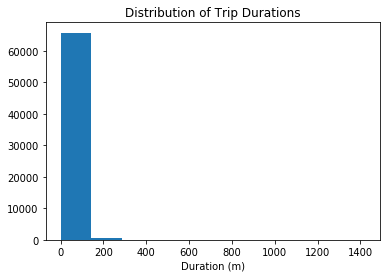

In [16]:
city_info = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC': './data/NYC-2016-Summary.csv'}

## Passing only 'Washington' for plotting the histogram.
## Storing the returned list in a variable and plotting the histogram using that variable.
data=plot_hist_of_trip_times_of_Washington(city_info['Washington'])
plt.hist(data)
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (m)')
plt.show()

The plot consists of one extremely tall bar on the left, maybe a very short second bar, and a whole lot of empty space in the center and right. This suggests that there are some highly infrequent outliers in the data. Instead of reprocessing the data, I will use additional parameters with the `.hist()` function to limit the range of data that is plotted.

**Question 4**: Using the parameters of the `.hist()` function to plot the distribution of trip times for the Subscribers in my selected city. Doing the same thing for only the Customers. Adding limits to the plots so that only trips of duration less than 75 minutes are plotted. As a bonus, setting the plots up so that bars are in five-minute wide intervals. For each group, where is the peak of each distribution? How would you describe the shape of each distribution?



In [17]:
def distribution_of_trip_times(filename):
    """
    This function reads in a file with trip data and returns the list of trip times for Subscribers and Customers.
    """
    with open(filename,'r') as f_in:
        
        ## Printing city name for reference
        city = filename.split('-')[0].split('/')[-1]
        print('\nCity: {}'.format(city))
        
        ## Setting up csv reader object
        reader=csv.DictReader(f_in)
        
        ## Creating empty lists to store trip times of Subscribers and Customers
        list_of_trip_times_Subs=[]
        list_of_trip_times_Cust=[]
        
        ## Appending all the trip times in the respective lists of Subscribers and Customers
        for row in reader:
            if row['user_type']=='Subscriber':
                list_of_trip_times_Subs.append(float(row['duration']))
            else:
                list_of_trip_times_Cust.append(float(row['duration']))
        
        ## Returning a tuple consisting of list of trip times of Subscribers and Customers.
        return (list_of_trip_times_Subs,list_of_trip_times_Cust)


City: Washington


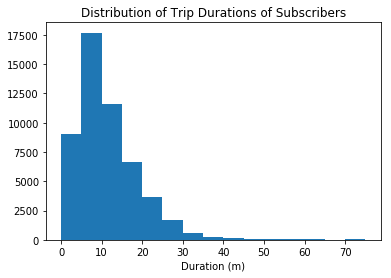

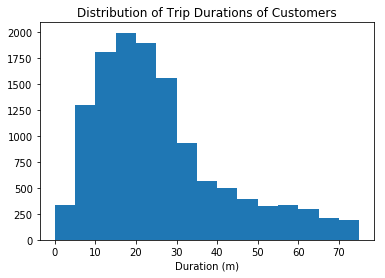

In [18]:
city_info = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC': './data/NYC-2016-Summary.csv'}

## Passing only 'Washington' for plotting the histogram.
## Storing the returned list in a variable and plotting the histogram using that variable.
data=distribution_of_trip_times(city_info['Washington'])

plt.hist(data[0],bins=[0,5, 10, 15, 20,25,30,35,40,45,50,55,60,65,70,75],range=(0,75))
plt.title('Distribution of Trip Durations of Subscribers')
plt.xlabel('Duration (m)')
plt.show()

plt.hist(data[1],bins=[0,5, 10, 15, 20,25,30,35,40,45,50,55,60,65,70,75],range=(0,75))
plt.title('Distribution of Trip Durations of Customers')
plt.xlabel('Duration (m)')
plt.show()

**Answer 4**: For the city of Washington: peak of Subscriber's distribution is between 5-10 minutes and that of Customer's is between 15-20 minutes. The shape of each distribution is first increasing tremendously and then later decreasing gradually.

<a id='eda_continued'></a>
## Performing One Last Analysis

**Question 5:** Taking a particular city, analyse the day_of_week in which most users share bike. Compare your analysis between Subscribers and Customers by making different visualizations for them.

In [19]:
def share_rides_day_analysis(filename):
    """
    This function reads in a file with trip data 
    and returns the list of amount of bike share rides taken day-wise for Subscribers and Customers.
    """
    with open(filename,'r') as f_in:
        
        ## Printing city name for reference
        city = filename.split('-')[0].split('/')[-1]
        print('\nCity: {}'.format(city))
        
        ## Setting up csv reader object
        reader=csv.DictReader(f_in)
        
        ## Creating empty lists to store day_of_week in which the trip was taken for Subscribers and Customers
        list_of_days_Subs=[]
        list_of_days_Cust=[]
        
        ## Appending all the day_of_week in the respective lists of Subscribers and Customers
        for row in reader:
            if row['user_type']=='Subscriber':
                list_of_days_Subs.append(row['day_of_week'])
            else:
                list_of_days_Cust.append(row['day_of_week'])
        
        ## Storing the count(number of trips taken on a particular day_of_week) in a list for Subscribers. 
        arr_sub=[0,0,0,0,0,0,0]
        for item_sub in list_of_days_Subs:
            if item_sub=='Sunday':
                arr_sub[0]+=1
            elif item_sub=='Monday':
                arr_sub[1]+=1
            elif item_sub=='Tuesday':
                arr_sub[2]+=1
            elif item_sub=='Wednesday':
                arr_sub[3]+=1
            elif item_sub=='Thursday':
                arr_sub[4]+=1
            elif item_sub=='Friday':
                arr_sub[5]+=1
            else:
                arr_sub[6]+=1
              
        ## Storing the count(number of trips taken on a particular day_of_week) in a list for Customers.     
        arr_cust=[0,0,0,0,0,0,0]
        for item_cust in list_of_days_Cust:
            if item_cust=='Sunday':
                arr_cust[0]+=1
            elif item_cust=='Monday':
                arr_cust[1]+=1
            elif item_cust=='Tuesday':
                arr_cust[2]+=1
            elif item_cust=='Wednesday':
                arr_cust[3]+=1
            elif item_cust=='Thursday':
                arr_cust[4]+=1
            elif item_cust=='Friday':
                arr_cust[5]+=1
            else:
                arr_cust[6]+=1
        
        ## Returning a tuple consisting of list of counts of number of trips taken on a particular day_of_week for Subscribers and Customers.
        return (arr_sub,arr_cust)


City: Washington


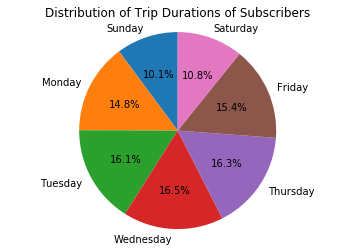

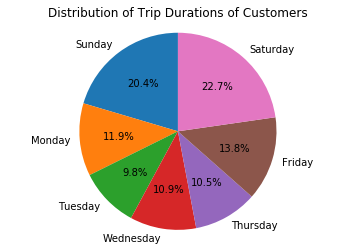

In [20]:
city_info = {'Washington': './data/Washington-2016-Summary.csv',
             'Chicago': './data/Chicago-2016-Summary.csv',
             'NYC': './data/NYC-2016-Summary.csv'}

# Passing only 'Washington' for plotting the pie chart.
# Storing the returned list in a variable and plotting the pie chart using that variable.
data=share_rides_day_analysis(city_info['Washington'])

labels='Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'
plt.pie(data[0], explode=None, labels=labels,autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Trip Durations of Subscribers')
plt.show()

plt.pie(data[1], explode=None, labels=labels,autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Trip Durations of Customers')
plt.show()

**Answer 5**: For the city of Washington: Subscribers take most rides on 'Wednesdays' while Customers take most rides on 'Saturdays'.

<a id='conclusions'></a>
## Conclusions

I've analysed the US Bike Share Data set and answered some of the possible questions that might be beneficial for the people riding or renting the bikes and even for the vendors. I've performed an initial exploration into the data available. I have compared the relative volume of trips made between three U.S. cities and the ratio of trips made by Subscribers and Customers. For one of these cities, I have investigated differences between Subscribers and Customers in terms of how long a typical trip lasts. 